# Simple Neural Network Model with different inputs

Input: testing different inputs

Output: optimal max-shape portfolio with normal restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model

In [3]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [4]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

Preparing outputs common for all models

In [5]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [6]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

## Defining models for different inputs

### DNN Model with a single fixed weight composite indicators

In [7]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_simple_composite_indicator(
        date, periods=6)
    x.append(indicators.values)

x_simple_composite_indicator = np.array(x)

x_train_simple_composite_indicator = x_simple_composite_indicator[:val_split]
x_val_simple_composite_indicator = x_simple_composite_indicator[val_split:test_split]
x_test_simple_composite_indicator = x_simple_composite_indicator[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8469 - val_loss: 2.6069 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5322 - val_loss: 2.3129 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2446 - val_loss: 2.0461 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9843 - val_loss: 1.8057 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7508 - val_loss: 1.5904 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5409 - val_loss: 1.3983 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3540 - val_loss: 1.2274 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1878 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0406 - val_loss: 0.9414 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

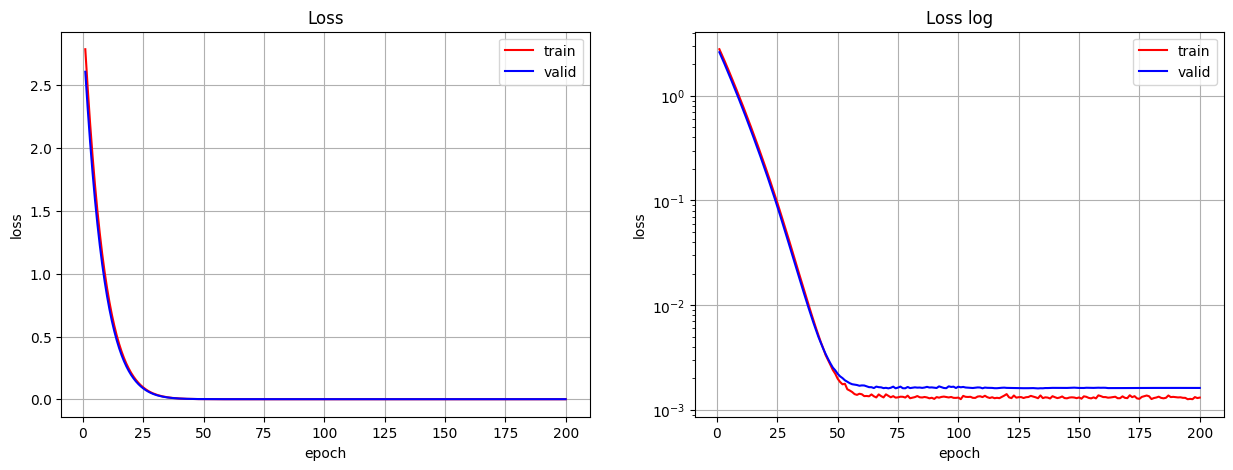

In [8]:
model_dnn_simple_composite_indicator = Sequential((
    Flatten(input_shape=x_train_simple_composite_indicator.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_simple_composite_indicator, 
                         x_train_simple_composite_indicator, y_train,
                         x_val_simple_composite_indicator, y_val, 
                         x_test_simple_composite_indicator, y_test)

### DNN Model with a single Manufacturing PMI indicator

In [9]:
indicator = 'Manufacturing PMI'
x = []
for date in days_to_recalculate:
    df = data_provider.get_key_indicator_values(indicator)
    df_normalized = data_provider.normilize_dataframe(df)
    df_last_values = data_provider.get_latest_data(
        indicator, df_normalized, date, periods=6)
    x.append(df_last_values.values)

x_manufacturing_pmi = np.array(x)

x_train_manufacturing_pmi = x_manufacturing_pmi[:val_split]
x_val_manufacturing_pmi = x_manufacturing_pmi[val_split:test_split]
x_test_manufacturing_pmi = x_manufacturing_pmi[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8274 - val_loss: 2.5877 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5134 - val_loss: 2.2942 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2268 - val_loss: 2.0280 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9664 - val_loss: 1.7883 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7334 - val_loss: 1.5737 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5240 - val_loss: 1.3825 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3382 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1730 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0263 - val_loss: 0.9285 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

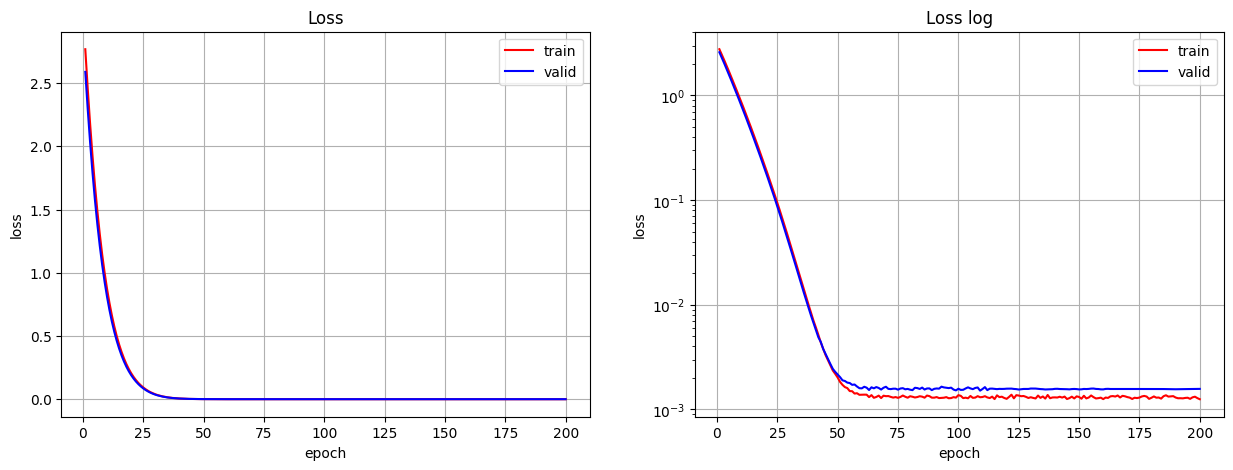

In [10]:
model_dnn_manufacturing_pmi = Sequential((
    Flatten(input_shape=x_train_manufacturing_pmi.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_manufacturing_pmi, 
                         x_train_manufacturing_pmi, y_train,
                         x_val_manufacturing_pmi, y_val, 
                         x_test_manufacturing_pmi, y_test)

### DNN Model with 6 separate indicators

In [11]:
x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in data_provider.key_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_indicators = np.array(x)

x_train_separate_indicators = x_separate_indicators[:val_split]
x_val_separate_indicators = x_separate_indicators[val_split:test_split]
x_test_separate_indicators = x_separate_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        15,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,027 (62.61 KB)

 Trainable params: 16,027 (62.61 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9243 - val_loss: 2.3542 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1962 - val_loss: 1.7391 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6144 - val_loss: 1.2591 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1631 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8228 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5716 - val_loss: 0.4285 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3902 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2622 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1733 - val_loss: 0.1259 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

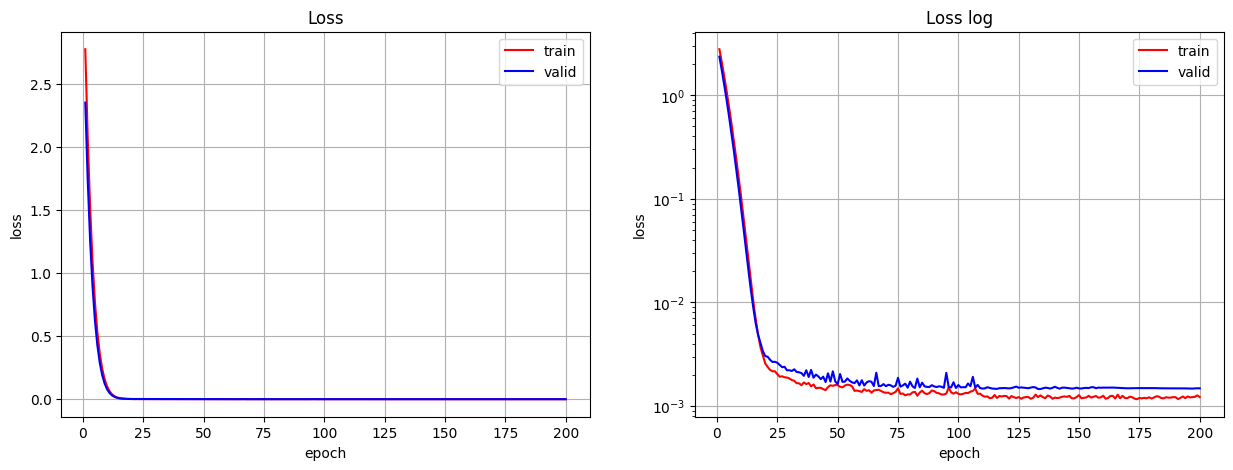

In [12]:
model_dnn_separate_indicators = Sequential((
    Flatten(input_shape=x_train_separate_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_indicators, 
                         x_train_separate_indicators, y_train,
                         x_val_separate_indicators, y_val, 
                         x_test_separate_indicators, y_test)

### DNN Model with 15 separate indicators

In [13]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in all_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_all_indicators = np.array(x)

x_train_separate_all_indicators = x_separate_all_indicators[:val_split]
x_val_separate_all_indicators = x_separate_all_indicators[val_split:test_split]
x_test_separate_all_indicators = x_separate_all_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2430)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │        38,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,355 (153.73 KB)

 Trainable params: 39,355 (153.73 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8869 - val_loss: 2.0311 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8144 - val_loss: 1.2194 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0751 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5982 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3107 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1500 - val_loss: 0.0821 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0675 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

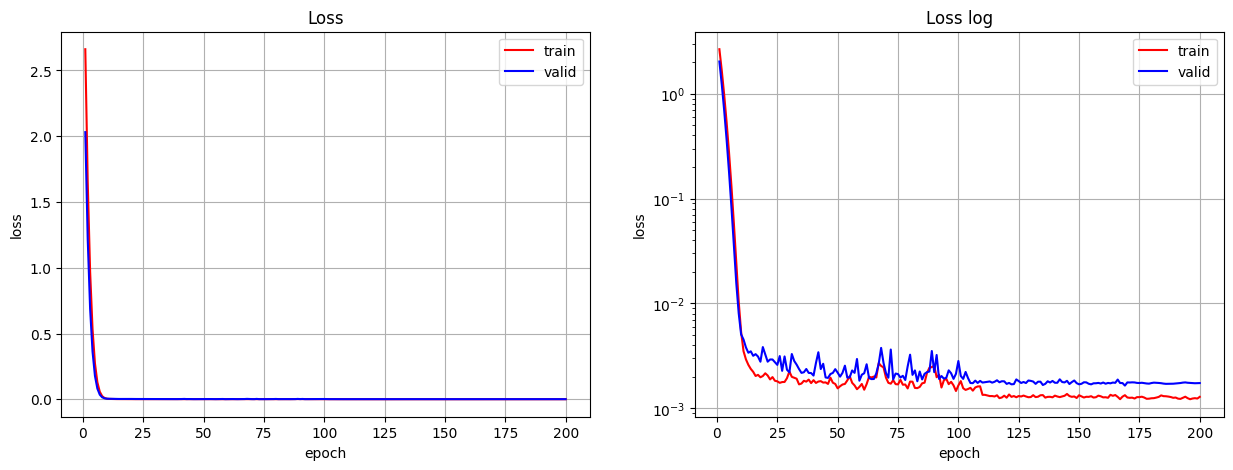

In [14]:
model_dnn_separate_all_indicators = Sequential((
    Flatten(input_shape=x_train_separate_all_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_all_indicators, 
                         x_train_separate_all_indicators, y_train,
                         x_val_separate_all_indicators, y_val, 
                         x_test_separate_all_indicators, y_test)

### DNN Model with single principal component from PCA

In [15]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=data_provider.key_indicators)
    x.append(indicators.values)

x_pca_component = np.array(x)

x_train_pca_component = x_pca_component[:val_split]
x_val_pca_component = x_pca_component[val_split:test_split]
x_test_pca_component = x_pca_component[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8066 - val_loss: 2.5669 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4940 - val_loss: 2.2749 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2083 - val_loss: 2.0100 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9501 - val_loss: 1.7715 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7175 - val_loss: 1.5581 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5099 - val_loss: 1.3680 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3250 - val_loss: 1.1991 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1608 - val_loss: 1.0495 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0157 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

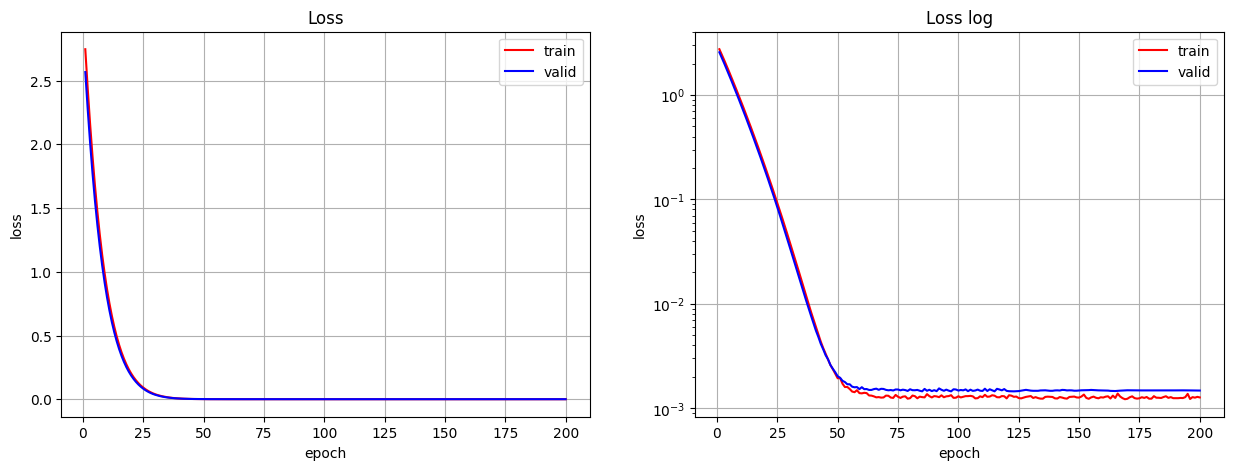

In [16]:
model_dnn_pca_component = Sequential((
    Flatten(input_shape=x_train_pca_component.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component, 
                         x_train_pca_component, y_train,
                         x_val_pca_component, y_val, 
                         x_test_pca_component, y_test)

### DNN Model with single principal component from PCA for all 15 indicators

In [17]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x_pca_component_all = np.array(x)

x_train_pca_component_all = x_pca_component_all[:val_split]
x_val_pca_component_all = x_pca_component_all[val_split:test_split]
x_test_pca_component_all = x_pca_component_all[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8404 - val_loss: 2.6001 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5270 - val_loss: 2.3080 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2408 - val_loss: 2.0430 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9823 - val_loss: 1.8042 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7491 - val_loss: 1.5901 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5409 - val_loss: 1.3989 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3546 - val_loss: 1.2286 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1891 - val_loss: 1.0773 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0418 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

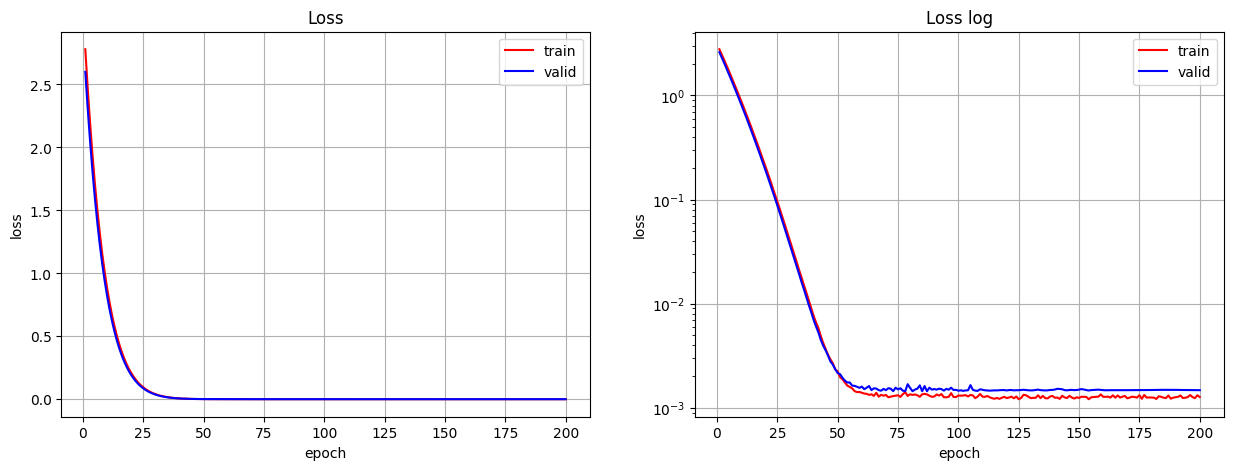

In [18]:
model_dnn_pca_component_all = Sequential((
    Flatten(input_shape=x_train_pca_component_all.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component_all, 
                         x_train_pca_component_all, y_train,
                         x_val_pca_component_all, y_val, 
                         x_test_pca_component_all, y_test)

### DNN Model with 2 principal components from PCA for all 15 indicators

In [19]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators
indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=2)
indicators

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
0,0.505049,0.002480,-0.507787,-0.439170,0.281551,0.437360,0.370907,-0.067983,0.539203,0.743291,...,-0.071401,-0.823839,1.644053,-0.015760,-1.202930,0.241381,0.836672,0.371536,0.667002,-0.689984
1,-0.015579,-2.797163,-0.771594,-0.336770,0.758930,0.057919,-0.209749,-3.153330,0.958272,-0.760032,...,2.005522,-0.359513,-0.057239,-1.547232,5.495179,4.056539,2.070630,-3.010675,-0.303433,-0.173633
2,0.626133,-0.390762,-0.539298,-0.608959,0.066066,0.524285,0.323646,-0.231878,0.691387,0.613439,...,-0.184726,-0.186334,1.268173,0.184019,-1.337547,0.315447,0.634291,0.221311,0.532231,-0.525886
3,0.079291,-2.443300,-1.353479,-0.384694,0.775196,-0.083013,-0.075151,-3.053944,0.111211,-0.925249,...,1.949574,-0.629443,0.220090,-1.824780,5.389675,4.055562,2.106551,-3.227986,-0.189357,-0.433236
4,0.713598,-0.309339,-0.458693,-0.520161,-0.140289,0.788309,0.399408,-0.118694,0.615379,0.526300,...,-0.511575,-0.902981,1.174534,0.441398,-1.541074,0.190962,0.775463,0.098667,0.497711,-0.809848
5,0.099598,-1.719970,-1.560667,-0.344515,0.877652,0.048258,-0.327511,-3.534290,0.829419,-0.849461,...,1.946382,-1.041209,0.958471,-2.185431,5.497495,3.564608,2.335864,-3.559904,-0.532470,-0.259486
6,0.997278,-0.748713,-0.786221,-0.311317,0.110698,0.591029,0.167454,0.202377,0.676159,0.638297,...,-0.056872,-1.091419,1.972584,0.402700,-1.215402,0.717610,0.636278,0.015852,0.489128,-0.573803
7,-0.094215,-2.669089,-0.550742,-0.443983,0.977445,0.028145,-0.211690,-3.537495,0.948593,-0.618920,...,1.910166,-0.941286,1.861746,-2.946752,5.312987,3.954217,2.276623,-3.495235,-0.661406,-0.069415
8,0.970167,-0.686446,-0.854593,-0.267714,0.193522,0.402433,0.051479,0.132980,0.140037,1.098918,...,-0.051316,-0.853694,1.660988,0.504193,-1.042943,0.381546,1.199114,-0.186334,0.909765,-0.785356
9,0.337803,-2.533037,-0.751107,0.005187,0.802895,-0.138397,-0.196281,-3.068420,1.190566,-0.615313,...,1.972234,-0.964242,2.373776,-2.929977,5.518822,3.762920,2.342735,-3.741473,-0.724154,0.226557


In [20]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=2)
    x.append(indicators.values)

x_pca_two_components = np.array(x)

x_train_pca_two_components = x_pca_two_components[:val_split]
x_val_pca_two_components = x_pca_two_components[val_split:test_split]
x_test_pca_two_components = x_pca_two_components[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,659 (22.11 KB)

 Trainable params: 5,659 (22.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9969 - val_loss: 2.6522 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5484 - val_loss: 2.2441 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1530 - val_loss: 1.8878 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8086 - val_loss: 1.5804 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5121 - val_loss: 1.3173 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2587 - val_loss: 1.0938 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0437 - val_loss: 0.9050 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8624 - val_loss: 0.7461 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7100 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

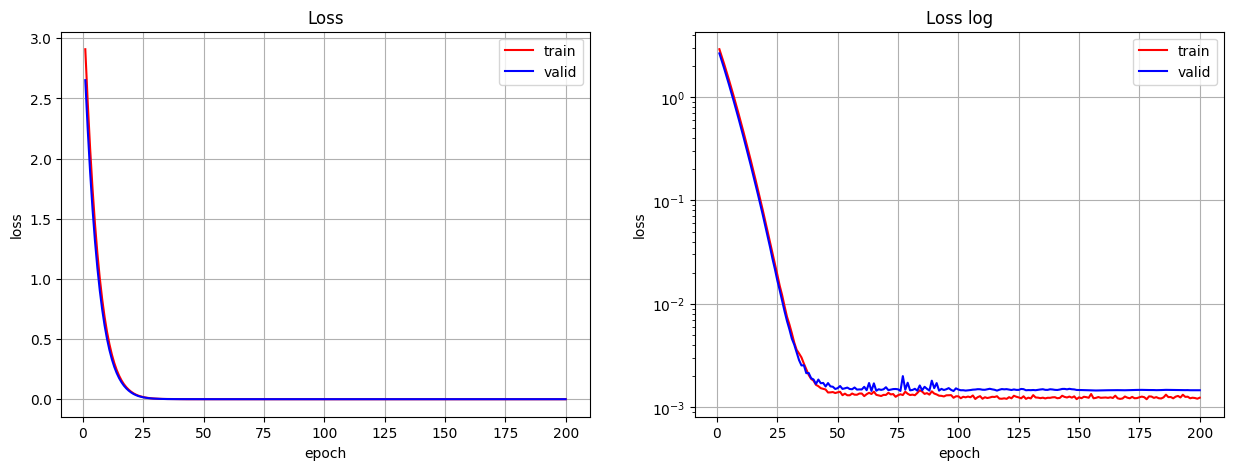

In [21]:
model_dnn_pca_two_components = Sequential((
    Flatten(input_shape=x_train_pca_two_components.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_two_components, 
                         x_train_pca_two_components, y_train,
                         x_val_pca_two_components, y_val, 
                         x_test_pca_two_components, y_test)

### DNN Model with 3 principal components from PCA for all 15 indicators

In [22]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=3)
    x.append(indicators.values)

x_pca_three_components = np.array(x)

x_train_pca_three_components = x_pca_three_components[:val_split]
x_val_pca_three_components = x_pca_three_components[val_split:test_split]
x_test_pca_three_components = x_pca_three_components[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 486)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         7,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,251 (32.23 KB)

 Trainable params: 8,251 (32.23 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9728 - val_loss: 2.5570 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4349 - val_loss: 2.0787 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9744 - val_loss: 1.6746 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5873 - val_loss: 1.3384 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2664 - val_loss: 1.0621 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0029 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7892 - val_loss: 0.6559 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6167 - val_loss: 0.5108 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4792 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

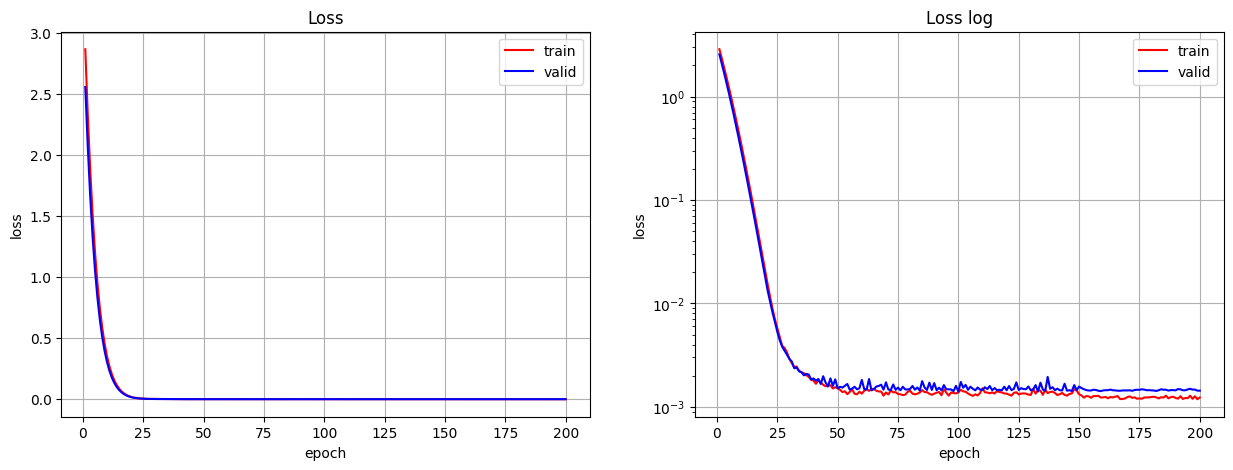

In [23]:
model_dnn_pca_three_components = Sequential((
    Flatten(input_shape=x_train_pca_three_components.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_three_components, 
                         x_train_pca_three_components, y_train,
                         x_val_pca_three_components, y_val, 
                         x_test_pca_three_components, y_test)

### DNN Model with single principal component from PCA for all 15 indicators + returns

In [24]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators + ['Monthly Returns']

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x_pca_component_all = np.array(x)

x_train_pca_component_all = x_pca_component_all[:val_split]
x_val_pca_component_all = x_pca_component_all[val_split:test_split]
x_test_pca_component_all_plus_returns = x_pca_component_all[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8324 - val_loss: 2.5931 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5179 - val_loss: 2.2990 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2307 - val_loss: 2.0322 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9707 - val_loss: 1.7919 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7364 - val_loss: 1.5767 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5267 - val_loss: 1.3846 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3403 - val_loss: 1.2138 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1739 - val_loss: 1.0624 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0264 - val_loss: 0.9281 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

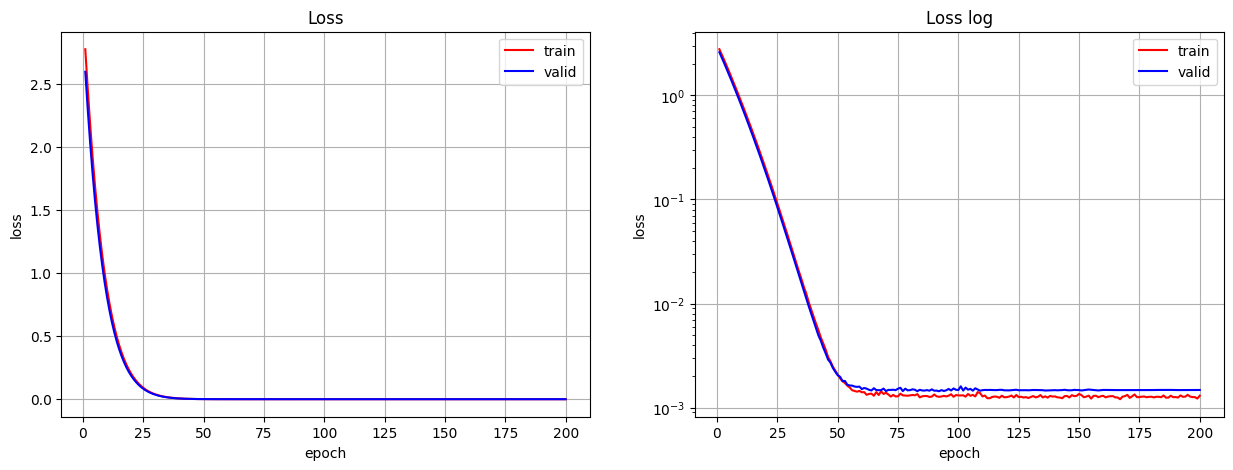

In [25]:
model_dnn_pca_component_all_plus_returns = Sequential((
    Flatten(input_shape=x_train_pca_component_all.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component_all_plus_returns, 
                         x_train_pca_component_all, y_train,
                         x_val_pca_component_all, y_val, 
                         x_test_pca_component_all_plus_returns, y_test)

### DNN Model with single principal component from PCA for all 15 indicators + economic cycle

In [26]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators + [
    'Economic Cycle X', 'Economic Cycle Y']

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x_pca_component_all = np.array(x)

x_train_pca_component_all = x_pca_component_all[:val_split]
x_val_pca_component_all = x_pca_component_all[val_split:test_split]
x_test_pca_component_all_plus_cycle = x_pca_component_all[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8838 - val_loss: 2.6401 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5657 - val_loss: 2.3432 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2748 - val_loss: 2.0736 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0113 - val_loss: 1.8306 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7742 - val_loss: 1.6129 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5624 - val_loss: 1.4185 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3734 - val_loss: 1.2456 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2050 - val_loss: 1.0919 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0556 - val_loss: 0.9558 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

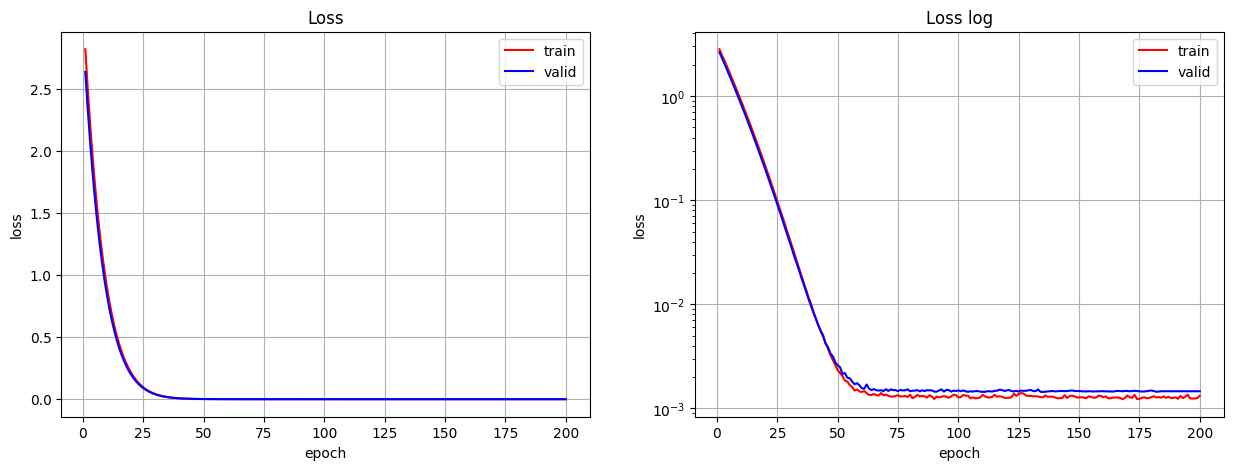

In [27]:
model_dnn_pca_component_all_plus_cycle = Sequential((
    Flatten(input_shape=x_train_pca_component_all.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component_all_plus_cycle, 
                         x_train_pca_component_all, y_train,
                         x_val_pca_component_all, y_val, 
                         x_test_pca_component_all_plus_cycle, y_test)

### DNN Model with single principal component from PCA for all 18 indicators

In [28]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators + [
    'Monthly Returns', 'Economic Cycle X', 'Economic Cycle Y']

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x_pca_component_all = np.array(x)

x_train_pca_component_all = x_pca_component_all[:val_split]
x_val_pca_component_all = x_pca_component_all[val_split:test_split]
x_test_pca_component_all_18 = x_pca_component_all[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8318 - val_loss: 2.5934 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5181 - val_loss: 2.3002 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2317 - val_loss: 2.0344 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9726 - val_loss: 1.7951 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7396 - val_loss: 1.5808 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5317 - val_loss: 1.3897 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3456 - val_loss: 1.2199 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1806 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0348 - val_loss: 0.9356 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

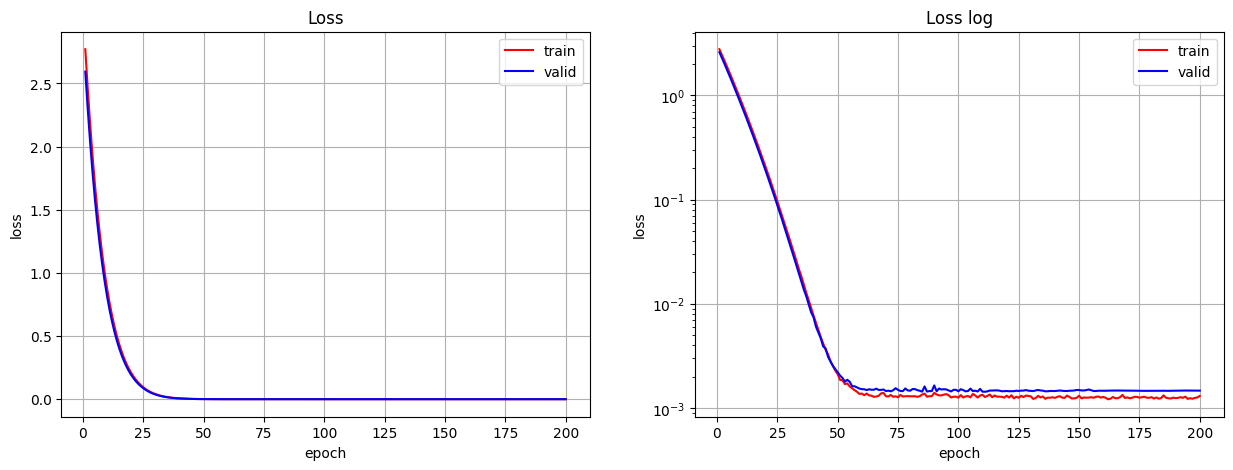

In [29]:
model_dnn_pca_component_all_18 = Sequential((
    Flatten(input_shape=x_train_pca_component_all.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component_all_18, 
                         x_train_pca_component_all, y_train,
                         x_val_pca_component_all, y_val, 
                         x_test_pca_component_all_18, y_test)

## Backtesting

In [30]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [31]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [32]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [33]:
(total_ret_simple_composite_indicator,
 cum_total_ret_simple_composite_indicator) = calculate_returns_for_model(
    model_dnn_simple_composite_indicator, x_test_simple_composite_indicator,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [34]:
(total_ret_manufacturing_pmi, 
 cum_total_ret_manufacturing_pmi) = calculate_returns_for_model(
    model_dnn_manufacturing_pmi, x_test_manufacturing_pmi,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [35]:
(total_ret_separate_indicators, 
 cum_total_ret_separate_indicators) = calculate_returns_for_model(
    model_dnn_separate_indicators, x_test_separate_indicators,
    dates_for_test, df_returns_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BC115DDEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [36]:
(total_ret_separate_all_indicators, 
 cum_total_ret_separate_all_indicators) = calculate_returns_for_model(
    model_dnn_separate_all_indicators, x_test_separate_all_indicators,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [37]:
(total_ret_pca_component, 
 cum_total_ret_pca_component) = calculate_returns_for_model(
    model_dnn_pca_component, x_test_pca_component,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [38]:
(total_ret_pca_component_all, 
 cum_total_ret_pca_component_all) = calculate_returns_for_model(
    model_dnn_pca_component_all, x_test_pca_component_all,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [39]:
(total_ret_pca_two_components, 
 cum_total_ret_pca_two_components) = calculate_returns_for_model(
    model_dnn_pca_two_components, x_test_pca_two_components,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [40]:
(total_ret_pca_three_components, 
 cum_total_ret_pca_three_components) = calculate_returns_for_model(
    model_dnn_pca_three_components, x_test_pca_three_components,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [41]:
(total_ret_pca_component_all_plus_returns, 
 cum_total_ret_pca_component_all_plus_returns) = calculate_returns_for_model(
    model_dnn_pca_component_all_plus_returns, x_test_pca_component_all_plus_returns,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [42]:
(total_ret_pca_component_all_plus_cycle, 
 cum_total_ret_pca_component_all_plus_cycle) = calculate_returns_for_model(
    model_dnn_pca_component_all_plus_cycle, x_test_pca_component_all_plus_cycle,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [43]:
(total_ret_pca_component_all_18, 
 cum_total_ret_pca_component_all_18) = calculate_returns_for_model(
    model_dnn_pca_component_all_18, x_test_pca_component_all_18,
    dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


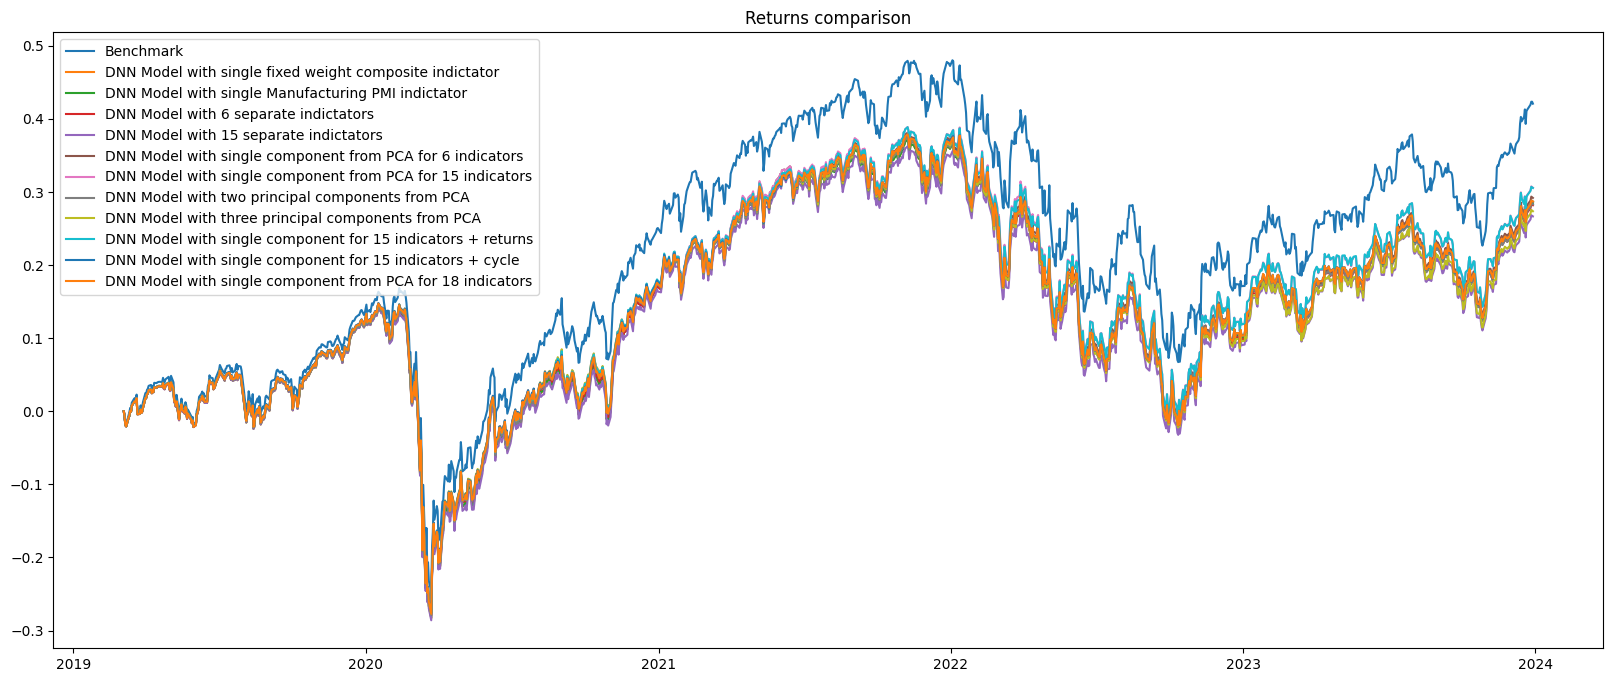

In [44]:
plt.figure(figsize=(20, 8))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_ret_simple_composite_indicator,
         label='DNN Model with single fixed weight composite indictator')
plt.plot(cum_total_ret_manufacturing_pmi,
         label='DNN Model with single Manufacturing PMI indictator')
plt.plot(cum_total_ret_separate_indicators,
         label='DNN Model with 6 separate indictators')
plt.plot(cum_total_ret_separate_all_indicators,
         label='DNN Model with 15 separate indictators')
plt.plot(cum_total_ret_pca_component,
         label='DNN Model with single component from PCA for 6 indicators')
plt.plot(cum_total_ret_pca_component_all,
         label='DNN Model with single component from PCA for 15 indicators')
plt.plot(cum_total_ret_pca_two_components,
         label='DNN Model with two principal components from PCA')
plt.plot(cum_total_ret_pca_three_components,
         label='DNN Model with three principal components from PCA')
plt.plot(cum_total_ret_pca_component_all_plus_returns,
         label='DNN Model with single component for 15 indicators + returns')
plt.plot(cum_total_ret_pca_component_all_plus_cycle,
         label='DNN Model with single component for 15 indicators + cycle')
plt.plot(cum_total_ret_pca_component_all_18,
         label='DNN Model with single component from PCA for 18 indicators')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [45]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_ret_simple_composite_indicator, df_results,
                  'DNN Model with single fixed weight composite indictator')
calculate_metrics(total_ret_manufacturing_pmi, df_results,
                  'DNN Model with single Manufacturing PMI indictator')
calculate_metrics(total_ret_separate_indicators, df_results,
                  'DNN Model with 6 separate indictators')
calculate_metrics(total_ret_separate_all_indicators, df_results,
                  'DNN Model with 15 separate indictators')
calculate_metrics(total_ret_pca_component, df_results,
                  'DNN Model with single component from PCA for 6 indicators')
calculate_metrics(total_ret_pca_component_all, df_results,
                  'DNN Model with single component from PCA for 15 indicators')
calculate_metrics(total_ret_pca_two_components, df_results,
                  'DNN Model with two principal components from PCA')
calculate_metrics(total_ret_pca_three_components, df_results,
                  'DNN Model with three principal components from PCA')
calculate_metrics(total_ret_pca_component_all_plus_returns, df_results,
                  'DNN Model with single component for 15 indicators + returns')
calculate_metrics(total_ret_pca_component_all_plus_cycle, df_results,
                  'DNN Model with single component for 15 indicators + cycle')
calculate_metrics(total_ret_pca_component_all_18, df_results,
                  'DNN Model with single component from PCA for 18 indicators')


df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model with single fixed weight composite indictator,0.054426,0.201408,0.270229
DNN Model with single Manufacturing PMI indictator,0.05403,0.201202,0.268536
DNN Model with 6 separate indictators,0.053537,0.20077,0.266659
DNN Model with 15 separate indictators,0.050917,0.201834,0.252271
DNN Model with single component from PCA for 6 indicators,0.055237,0.201167,0.274584
DNN Model with single component from PCA for 15 indicators,0.057581,0.201007,0.286464
DNN Model with two principal components from PCA,0.05374,0.200436,0.268114
DNN Model with three principal components from PCA,0.052131,0.200854,0.259547
DNN Model with single component for 15 indicators + returns,0.057538,0.200294,0.287266
